# Find the fingerprints of ENSO and the IPO in observed gridded datasets

Purpose
-------

    1.    Decompose the temperature time series into Intrinsic Mode Functions (IMFs) using EMD.
            i)  remove monthly climatology
            ii) remove linear trend over timeseries
    2.    Identify and correlate relevant IMFs with known indices for ENSO and IPO.
    3.    Compute slope of relationship between ENSO/IPO and variable of interest to quantify effect of ENSO/IPO


### IMPORTS

In [1]:

import sys
import os
import glob

import numpy as np
import pandas as pd
import xarray as xr

import matplotlib.pyplot as plt
from matplotlib import ticker
from matplotlib.gridspec import GridSpec
import matplotlib.colors as mcolors
import cmocean.cm as cmo
from cmocean.tools import lighten
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# oceanographic
import gsw as gsw

# statistics
import scipy as sci
from scipy.signal import hilbert
from PyEMD import EMD

# regridding package
import xesmf as xe

# Copernicus marine toolbox
#import copernicusmarine
#from pprint import pprint
#copernicusmarine.login()

# print versions of packages
print("python version =",sys.version[:5])
print("numpy version =", np.__version__)
print("pandas version =", pd.__version__)
print("scipy version =", sci.__version__)
print("xarray version =", xr.__version__)
print("xesmf version =", xe.__version__)
print("cartopy version =", sys.modules[ccrs.__package__].__version__)
print("matplotlib version =", sys.modules[plt.__package__].__version__)
print("cmocean version =", sys.modules[cmo.__package__].__version__)


wrkdir="/g/data/es60/pjb581/SPC"
os.chdir(wrkdir)
os.getcwd()


/g/data/es60/pjb581/miniforge3/envs/pyEMD_env/lib/python3.10/site-packages/esmpy/interface/loadESMF.py:94: VersionWarning: ESMF installation version 8.8.0, ESMPy version 8.8.0b0
  warnings.warn("ESMF installation version {}, ESMPy version {}".format(


python version = 3.10.
numpy version = 2.1.3
pandas version = 2.2.3
scipy version = 1.15.1
xarray version = 2024.11.0
xesmf version = 0.8.8
cartopy version = 0.24.1
matplotlib version = 3.10.0
cmocean version = v3.0.3


'/g/data/es60/pjb581/SPC'

### LOAD DATA

In [4]:
%%time

datapath = "/g/data/es60/observations/EN4"

# 1. Use glob to get all matching files
files = glob.glob(datapath + "/EN*.nc")

# 2. Pass the list to open_mfdataset
all_ds = xr.open_mfdataset(files, combine='by_coords').squeeze()
all_ds


CPU times: user 12.2 ms, sys: 8.55 ms, total: 20.7 ms
Wall time: 18.8 ms


{'r39i1p1f1': <xarray.Dataset> Size: 7GB
 Dimensions:              (IMF: 3, time: 1980, j: 300, i: 360)
 Coordinates:
   * IMF                  (IMF) int64 24B 1 2 3
   * time                 (time) datetime64[ns] 16kB 1850-01-16T12:00:00 ... 2...
   * j                    (j) int32 1kB 0 1 2 3 4 5 6 ... 294 295 296 297 298 299
   * i                    (i) int32 1kB 0 1 2 3 4 5 6 ... 354 355 356 357 358 359
     longitude            (j, i) float64 864kB ...
     latitude             (j, i) float64 864kB ...
 Data variables:
     r39i1p1f1_sst_imfs   (IMF, time, j, i) float64 5GB ...
     r39i1p1f1_sst_anom   (time, j, i) float32 855MB ...
     r39i1p1f1_sst_detr   (time, j, i) float32 855MB ...
     r39i1p1f1_sst_trend  (j, i) float32 432kB ...}

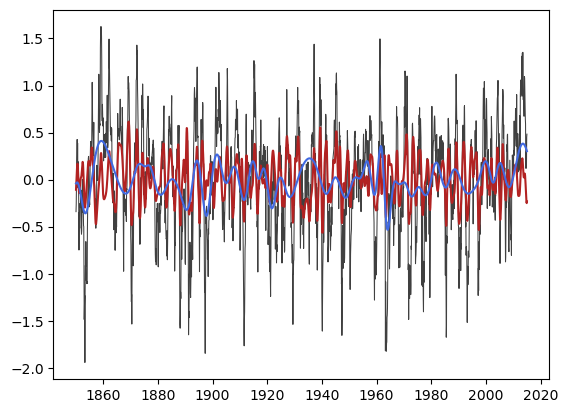

In [11]:
plt.figure()
plt.plot(all_ds['temperature'].sel(lon=180.0, lat=-10.0, depth=5.0, method='nearest'))


## cut the data to post-2005 (i.e., Argo era)

In [ ]:
all_ds = all_ds.sel(time=slice("2005-01-01","2024-12-31"))
all_ds = all_ds.drop_vars(["temperature_uncertainty", "salinity_uncertainty", "temperature_observation_weights", "salinity_observation_weights"])
all_ds

## remove the monthly climatology from the SST

In [ ]:
new_depth = np.arange(5,2001,10)
new_depth_thick = np.arange(0,2001,10)
new_depth_thick[0] = 0; new_depth_thick[-1] = 2000; 
new_depth_thick = np.diff(new_depth_thick)
print(len(new_depth), len(new_depth_thick))

new_depth_thick = new_depth_thick[:, np.newaxis, np.newaxis]
new_depth_thick = np.broadcast_to(new_depth_thick, (200,173,360))

dep_thick = xr.DataArray(
    new_depth_thick,
    dims=["depth", "lat", "lon"],
    coords={"depth": new_depth, "lon":all_ds.coords["lon"].values, "lat":all_ds.coords["lat"].values}
    )


In [ ]:
%%time

for var in all_ds.data_vars:
    print(f"{var} Gb: {all_ds[var].nbytes * 1e-9}")

all_ds = all_ds.compute()


In [ ]:
%%time

temp_lin = all_ds.temperature.where(all_ds.salinity>0.0, other=np.nan).sel(depth=slice(0,2000)).interp(depth=new_depth, method='linear')
salt_lin = all_ds.salinity.where(all_ds.salinity>0.0, other=np.nan).sel(depth=slice(0,2000)).interp(depth=new_depth, method='linear')

temp = all_ds.temperature.where(all_ds.salinity>0.0, other=np.nan).interpolate_na(dim='lon', method='linear').interpolate_na(dim='lat', method='linear').interpolate_na(dim='depth', method='linear')
salt = all_ds.salinity.where(all_ds.salinity>0.0, other=np.nan).interpolate_na(dim='lon', method='linear').interpolate_na(dim='lat', method='linear').interpolate_na(dim='depth', method='linear')

temp = temp.where(~np.isnan(salt),other=0.0).sel(depth=slice(0,2000))
salt = salt.where(~np.isnan(salt),other=0.0).sel(depth=slice(0,2000))

temp_cub = temp.interp(depth=new_depth, method='cubic').where(salt_lin>0.0, other=np.nan)
salt_cub = salt.interp(depth=new_depth, method='cubic').where(salt_lin>0.0, other=np.nan)


In [ ]:
temp_cub

## Calculate density from temperature and salinity

In [ ]:
%%time

rho0_lin = gsw.density.sigma0(salt_lin, temp_lin-273.15)
rho0_cub = gsw.density.sigma0(salt_cub, temp_cub-273.15)

# mask rho0 where there are zeros
rho0_lin = rho0_lin.where(rho0_lin > 0.0, other=np.nan)
rho0_cub = rho0_cub.where(rho0_cub > 0.0, other=np.nan)


## Compute MLD from a density threshold criterion

In [9]:
%%time

def compute_mld(rho_profile, depth, criterion=0.1):
    """
    Compute the mixed layer depth (MLD) for a single vertical column.
    
    Parameters:
      rho_profile : 1D numpy array
          Density profile (kg/m^3) along the depth dimension.
      depth : 1D numpy array
          Depth levels corresponding to the density profile.
      criterion : float, optional
          The density difference criterion (default is 0.1 kg/m^3).
    
    Returns:
      mld : float
          The estimated mixed layer depth. Returns np.nan if the criterion
          is never reached.
    """
    # Calculate the density difference relative to the surface
    drho = rho_profile - rho_profile[0]
    
    # Find the first index where the density difference exceeds the criterion
    idx = np.where(drho >= criterion)[0]
    if len(idx) == 0:
        # If no level meets the criterion, return NaN (or you could choose the deepest level)
        return np.nan
    
    i = idx[0]
    
    # If the criterion is met in the very first level, return the top depth.
    if i == 0:
        return depth[0]
    
    # For a more accurate estimate, linearly interpolate between levels i-1 and i.
    d1, d2 = depth[i-1], depth[i]
    drho1, drho2 = drho[i-1], drho[i]
    
    # Calculate the fractional distance between the two depths where the threshold is met.
    frac = (criterion - drho1) / (drho2 - drho1)
    mld = d1 + frac * (d2 - d1)
    return mld


# Now, use xr.apply_ufunc to apply compute_mld to each vertical column in your dataset.
# Here, we assume that rho is an xarray DataArray with coordinate "depth".
mld = xr.apply_ufunc(
    compute_mld,
    rho0_cub.isel(depth=slice(1,120)),               # the density field
    rho0_cub.isel(depth=slice(1,120))['depth'],      # the depth coordinate (assumed to be 1D)
    input_core_dims=[['depth'], ['depth']],  # indicate that both inputs have a "depth" dimension
    vectorize=True,    # vectorize over lat and lon
    kwargs={'criterion': 0.1},
    output_dtypes=[float]
)



CPU times: user 1min 38s, sys: 819 ms, total: 1min 39s
Wall time: 1min 39s


## Save the MLD variable to netcdf


In [19]:
sst = all_ds['temperature'].isel(depth=0)

mld.name = "mld"
mld.to_netcdf("/g/data/es60/pjb581/SPC/data/EN4_mld_2005-2024.nc")
sst.name = "sst"
sst.to_netcdf("/g/data/es60/pjb581/SPC/data/EN4_sst_2005-2024.nc")


## Load the MLD and SST datasets

In [2]:
%%time

mld = xr.open_dataset("/g/data/es60/pjb581/SPC/data/EN4_mld_2005-2024.nc")['mld']
sst = xr.open_dataset("/g/data/es60/pjb581/SPC/data/EN4_sst_2005-2024.nc")['sst']


CPU times: user 75.3 ms, sys: 63.4 ms, total: 139 ms
Wall time: 807 ms


## Take the monthly anomaly in SST and MLDs

CPU times: user 5.74 s, sys: 699 ms, total: 6.44 s
Wall time: 7.19 s


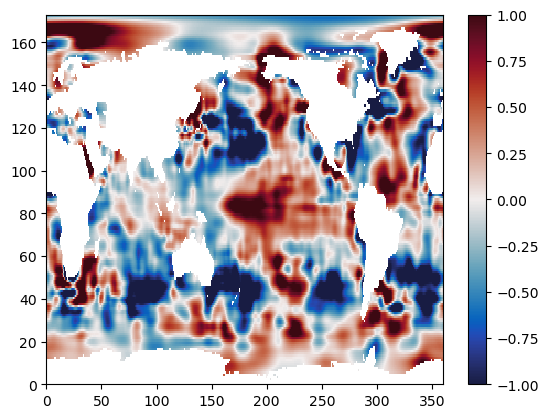

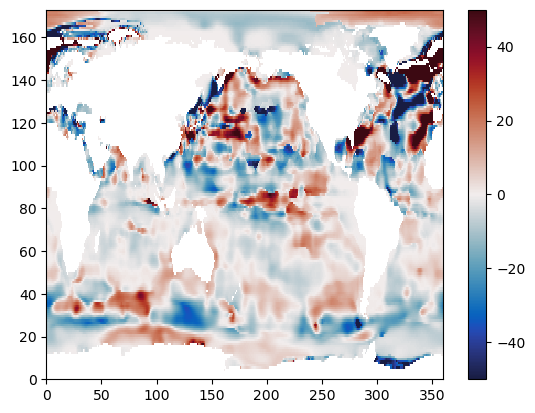

In [3]:
%%time

sst_clim = sst.groupby('time.month').mean('time')
sst_anom = sst.groupby('time.month') - sst_clim

mld_clim = mld.groupby('time.month').mean('time')
mld_anom = mld.groupby('time.month') - mld_clim

plt.figure()
plt.pcolormesh(sst_anom.isel(time=0), cmap=cmo.balance, vmin=-1, vmax=1)
plt.colorbar()

plt.figure()
plt.pcolormesh(mld_anom.isel(time=0), cmap=cmo.balance, vmin=-50, vmax=50)
plt.colorbar()


## detrend the SST and MLD datasets

In [4]:
%%time

### remove global trend
def detrend_1d(arr):
    """Remove the linear trend from a 1D array."""
    x = np.arange(len(arr))
    # Fit a linear trend
    coeffs = np.polyfit(x, arr, 1)
    trend = np.polyval(coeffs, x)
    # Remove the trend
    detrended = arr - trend
    return detrended

sst_detr = xr.apply_ufunc(
    detrend_1d,
    sst_anom,
    input_core_dims=[['time']],
    output_core_dims=[['time']],
    vectorize=True,
    dask='parallelized',
    output_dtypes=[sst_anom.dtype]
)

mld_detr = xr.apply_ufunc(
    detrend_1d,
    mld_anom,
    input_core_dims=[['time']],
    output_core_dims=[['time']],
    vectorize=True,
    dask='parallelized',
    output_dtypes=[mld_anom.dtype]
)



CPU times: user 14.8 s, sys: 1.42 s, total: 16.3 s
Wall time: 14.5 s


## determine the linear trends since 2005

CPU times: user 203 ms, sys: 57.5 ms, total: 261 ms
Wall time: 259 ms


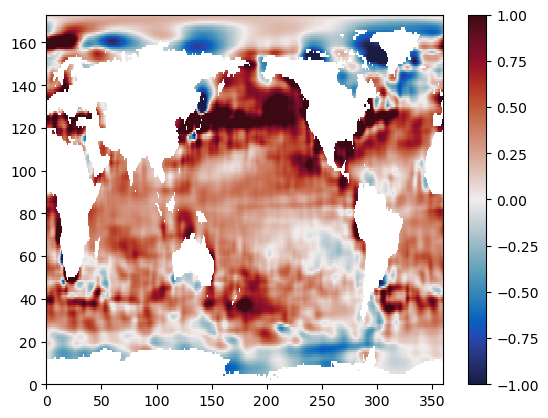

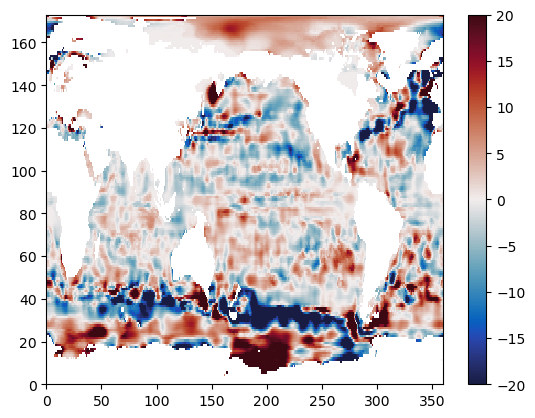

In [5]:
%%time

### retrive the linear least squares trend
sst_trend = sst_anom - sst_detr
mld_trend = mld_anom - mld_detr

### since the trends are linear, they can be described by one number (their slope)
### calculate the slope on a decadal timescale
dates = sst_anom.coords['time']
sst_trend = sst_trend.sel(time=dates[-1]) - sst_trend.sel(time=dates[0]) / len(dates) * 12 * 10
mld_trend = mld_trend.sel(time=dates[-1]) - mld_trend.sel(time=dates[0]) / len(dates) * 12 * 10

plt.figure()
plt.pcolormesh(sst_trend, cmap=cmo.balance, vmin=-1, vmax=1)
plt.colorbar()

plt.figure()
plt.pcolormesh(mld_trend, cmap=cmo.balance, vmin=-20, vmax=20)
plt.colorbar()


## Undertake the decomposition at each grid cell across the ocean

In [6]:
%%time

import signal
emd = EMD()

years = np.arange(2005+0.5/12, 2024+11.51/12, 1/12)
times = sst_anom.coords['time'].values
lats = sst_anom.coords['lat'].values
lons = sst_anom.coords['lon'].values
sst_imfs = np.zeros((3,len(times),len(lats),len(lons)))
mld_imfs = np.zeros((3,len(times),len(lats),len(lons)))

## Define a timeout handler
#def timeout_handler(signum, frame):
#    raise TimeoutError

## Register the timeout handler for the alarm signal
#signal.signal(signal.SIGALRM, timeout_handler)

def find_imf_freq(imfs):
    inst_freqs = []
    for imf in imfs:
        analytic_signal = hilbert(imf)
        amplitude_envelope = np.abs(analytic_signal)
        instantaneous_phase = np.unwrap(np.angle(analytic_signal))
        instantaneous_frequency = np.diff(instantaneous_phase) / (2.0 * np.pi * np.diff(years))
        inst_freqs.append(instantaneous_frequency)
    return np.array([np.mean(freq) for freq in inst_freqs])
    

def set_imfs(imfs, freqs):
    # add IMFs to the master array and merge IMFs into sub-annual, inter-annual, decadal and trend
    lentmp = np.shape(imfs)[0]
    if lentmp > 0:
        mask1 = freqs > 1                       # oscillates with period less than 1 year
        mask2 = (freqs < 1) & (freqs > 0.2)     # oscillates with period between 1 and 5 years
        mask3 = (freqs < 0.2) & (freqs > 0.0)   # oscillates with period greater than 5 years
        out1 = np.mean(imfs[mask1],axis=0)
        out2 = np.mean(imfs[mask2],axis=0)
        out3 = np.mean(imfs[mask3],axis=0)
    else:
        out1 = np.zeros(len(sstimfs[0,:]))
        out2 = np.zeros(len(sstimfs[0,:]))
        out3 = np.zeros(len(sstimfs[0,:]))
    return np.array([out1, out2, out3])



CPU times: user 712 μs, sys: 0 ns, total: 712 μs
Wall time: 566 μs


## run the loop

In [7]:
for ix,lon in enumerate(lons[0:-1]):
    if ix % 10 == 0:
        print(ix)
    for iy,lat in enumerate(lats[0:-1]):
        #signal.alarm(180)
        
        # decompose
        #try:
        sstimfs = emd(sst_detr.isel(lon=ix, lat=iy).values, max_imf=5)
        mldimfs = emd(mld_detr.isel(lon=ix, lat=iy).values, max_imf=5)
        #except TimeoutError:
        #    print("timed out at x=%i and y=%i"%(ix,iy))
            
        # check that the IMFs are actually valid and not spurious
        #sumrow = np.abs(np.sum(imfs, axis=1))
        #mask = sumrow >= 1e-2
        #imfs = imfs[mask]
        
        # determine the frequencies of the IMFs
        sst_freqs = find_imf_freq(sstimfs)
        mld_freqs = find_imf_freq(mldimfs)
        
        # add IMFs to the master array and merge IMFs into sub-annual, inter-annual, decadal and trend
        sst_imfs[:,:,iy,ix] = set_imfs(sstimfs, sst_freqs)
        mld_imfs[:,:,iy,ix] = set_imfs(mldimfs, mld_freqs)



0


/g/data/es60/pjb581/miniforge3/envs/pyEMD_env/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/g/data/es60/pjb581/miniforge3/envs/pyEMD_env/lib/python3.10/site-packages/numpy/_core/_methods.py:139: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350


In [10]:

# Create xarray Datasets
imfs_sst_ds = xr.Dataset(
    {
        "sst_imfs": (["IMF", "time", "lat", "lon"], sst_imfs),
        "sst_anom": (["time", "lat", "lon"], sst_anom.values),
        "sst_detr": (["time", "lat", "lon"], sst_detr.transpose("time", "lat", "lon").values),
        "sst_trend": (["lat", "lon"], sst_trend.values),
    },
    coords={
        "IMF": np.arange(1,4,1),
        "time": dates,
        "lat": lats,
        "lon": lons,
    },
)

imfs_mld_ds = xr.Dataset(
    {
        "mld_imfs": (["IMF", "time", "lat", "lon"], mld_imfs),
        "mld_anom": (["time", "lat", "lon"], mld_anom.values),
        "mld_detr": (["time", "lat", "lon"], mld_detr.transpose("time", "lat", "lon").values),
        "mld_trend": (["lat", "lon"], mld_trend.values),
    },
    coords={
        "IMF": np.arange(1,4,1),
        "time": dates,
        "lat": lats,
        "lon": lons,
    },
)
os.chdir(wrkdir + "/data/")

os.remove("imfs_sst.nc")
os.remove("imfs_mld.nc")

imfs_sst_ds.to_netcdf("imfs_sst.nc")
imfs_mld_ds.to_netcdf("imfs_mld.nc")
